# Yelp Data Challenge - Restaurant Recommender

BitTiger DS501

Jun 2017

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('yelp_dataset_challenge_round9/last_2_years_restaurant_reviews.csv')

In [3]:
df.shape

(111548, 13)

In [4]:
df.head(2)

,business_id,name,categories,ave_stars,cool,date,funny,review_id,stars,text,type,useful,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"[Steakhouses, Restaurants, Cajun/Creole]",4.0,0,2016-07-28,0,iHP55csZHjPGqOMwIo70qQ,5,Exceptional...exceptional steakhouse!! Ordered...,review,0,TU5j2S_Ub__ojLOpD_UepQ
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"[Steakhouses, Restaurants, Cajun/Creole]",4.0,0,2016-07-17,0,GWI2xpBBwxK9-w1etLz51A,5,In a city with overrated 'celebrity' steakhous...,review,0,OC_WdUmY2fK-c1SD4JqSsw


## 1. Clean data and get rating data 

#### Select relevant columns in the original dataframe

In [5]:
# Get business_id, user_id, stars for recommender
col_select = ["business_id", "user_id", "stars"]
df_select = df[col_select]
df_select.head(2)

,business_id,user_id,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,TU5j2S_Ub__ojLOpD_UepQ,5
1,--9e1ONYQuAa-CB_Rrw7Tw,OC_WdUmY2fK-c1SD4JqSsw,5


#### There are many users that haven't given many reviews, exclude these users from the item-item similarity recommender

**Q**: How do we recommend to these users anyways?

In [6]:
# To be implemented
# review count for each user
n_review_per_user = df_select["user_id"].value_counts()
n_review_per_user.shape #total number of users in this df

(64047L,)

In [7]:
# set minimum review number for user
min_review = 1

# percentage of user with minimum review
1.0*(n_review_per_user <= min_review).sum()/n_review_per_user.shape[0] 

0.70936968164004555

In [8]:
# keep users with review number above minimum review
user_filter = (n_review_per_user > min_review).astype(int).nonzero()[0]
user_filter = list(n_review_per_user.index[user_filter])
user_to_keep = df_select["user_id"].apply(lambda x: x in user_filter)

In [9]:
df_select_min_review = df_select[user_to_keep]
df_select_min_review.shape

(66115, 3)

In [10]:
df_select_min_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66115 entries, 0 to 111546
Data columns (total 3 columns):
business_id    66115 non-null object
user_id        66115 non-null object
stars          66115 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


#### Create utility matrix from records

In [11]:
# To be implemented
from scipy import sparse

n_users = df_select_min_review["user_id"].value_counts().shape[0]
n_business = df_select_min_review["business_id"].value_counts().shape[0]

utility_mat = sparse.lil_matrix((n_users, n_business))
utility_mat

<18614x3508 sparse matrix of type '<type 'numpy.float64'>'
	with 0 stored elements in LInked List format>

In [12]:
business_id_dict = {}
user_id_dict = {}

business_ind = 0
user_ind = 0

for _, row in df_select_min_review.iterrows():
   
    if row["business_id"] not in business_id_dict:
        business_id_dict[row["business_id"]] = business_ind
        business_ind +=1
    if row["user_id"] not in user_id_dict:
        user_id_dict[row["user_id"]] = user_ind
        user_ind +=1
    
    utility_mat[user_id_dict[row["user_id"]], business_id_dict[row["business_id"]]] = row["stars"]


In [13]:
utility_mat 

<18614x3508 sparse matrix of type '<type 'numpy.float64'>'
	with 66115 stored elements in LInked List format>

## 2. Item-Item similarity recommender

### Let's reuse the ItemItemRecommender class derived from previous exercise

Hint: we need to make modification to accommodate the dense numpy array

In [14]:
# To be implemented
from sklearn.metrics.pairwise import cosine_similarity
from time import time


class ItemItemRecommender(object):

    def __init__(self, neighborhood_size):
        self.neighborhood_size = neighborhood_size

    def fit(self, ratings_mat):
        self.ratings_mat = ratings_mat
        self.n_users = ratings_mat.shape[0]
        self.n_items = ratings_mat.shape[1]
        self.item_sim_mat = cosine_similarity(self.ratings_mat.T)
        self._set_neighborhoods()

    def _set_neighborhoods(self):
        least_to_most_sim_indexes = np.argsort(self.item_sim_mat, 1)
        self.neighborhoods = least_to_most_sim_indexes[:, -self.neighborhood_size:]

    def pred_one_user(self, user_id, report_run_time=False):
        start_time = time()
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1] # 0 is row index, 1 is col index
        # Just initializing so we have somewhere to put rating preds
        out = np.zeros(self.n_items)
        for item_to_rate in range(self.n_items):
            relevant_items = np.intersect1d(self.neighborhoods[item_to_rate],
                                            items_rated_by_this_user,
                                            assume_unique=True)  # assume_unique speeds up intersection op
            out[item_to_rate] = self.ratings_mat[user_id, relevant_items] * \
                self.item_sim_mat[item_to_rate, relevant_items] / \
                self.item_sim_mat[item_to_rate, relevant_items].sum()
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        cleaned_out = np.nan_to_num(out)
        return cleaned_out

    def pred_all_users(self, report_run_time=False):
        start_time = time()
        all_ratings = [
            self.pred_one_user(user_id) for user_id in range(self.n_users)]
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        return np.array(all_ratings)

    def top_n_recs(self, user_id, n):
        pred_ratings = self.pred_one_user(user_id)
        item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                        if item not in items_rated_by_this_user]
        return unrated_items_by_pred_rating[-n:]

In [15]:
my_rec_engine = ItemItemRecommender(neighborhood_size=75)
my_rec_engine.fit(utility_mat)
user_1_preds = my_rec_engine.pred_one_user(user_id=1, report_run_time=True)
# Show predicted ratings for user #1 on first 100 items
print(my_rec_engine.top_n_recs(2, 20))

Execution time: 1.291000 seconds
[2421, 1171, 717, 1925, 534, 2579, 3155, 630, 970, 3011, 1439, 3086, 963, 2393, 1406, 1859, 1717, 869, 628, 1632]


## 3. Matrix Factorization recommender

Take a look at Graphlab Create examples

In [27]:
from sklearn.decomposition import NMF

def fit_nmf(matrix, n, alpha = 0.01, random_state = 100):
    mat = matrix
    nmf = NMF(n_components = n, alpha = alpha, random_state = random_state )
    nmf.fit(mat)
    return nmf.reconstruction_err_

In [38]:
n_range = range(10, 51, 10)
error = [fit_nmf(utility_mat, n) for n in n_range]

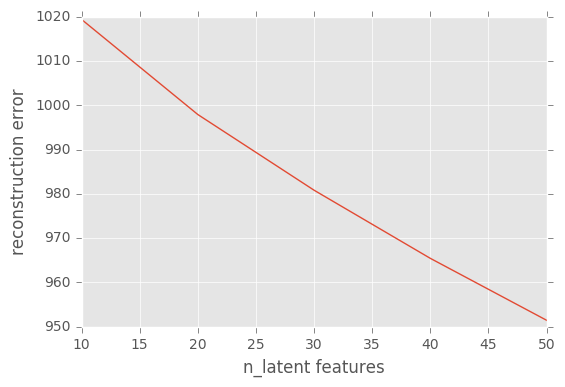

In [39]:
plt.plot(n_range, error)
plt.xlabel('n_latent features')
plt.ylabel('reconstruction error')

It looks like that at higher number of features, the reconstruction error is small. However, due to the limit of my computer's power, I cannot go further on larger number of latent features. 

## 4. Other recommenders (optional)

What are other ways you can build a better recommender?

* Other features (have you noticed there are other features in the Yelp dataset, e.g. tips, etc.?)
* Popularity-based
* Content-based
* Hybrid